## Tarea 03 - Aprendizaje maquina

#### Giovanni Gamaliel López Padilla

Se utilizo el modelo creacdo en la tarea pasada. Se uso un fine-tunning al modelo VGG16 añadiendo una capa flatten y dos densas.

In [ ]:
from keras.applications.imagenet_utils import preprocess_input
from keras.preprocessing.image import ImageDataGenerator,img_to_array
from skimage.transform import resize
import tensorflow.keras as keras
import matplotlib.pyplot as plt
from keras import optimizers
from os import listdir as ls
import matplotlib.cm as cm
from keras import models
from keras import layers
from os.path import join
import tensorflow as tf
from PIL import Image
import numpy as np

In [ ]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, classifier_layer_names):
    # Modelo que mapea la imagen de entrada a la capa convolucional última,
    # donde se calculará la activación
    last_conv_layer  = model.get_layer('vgg16').get_layer(last_conv_layer_name)
    conv_model       = keras.Model(model.get_layer('vgg16').inputs,
                                   last_conv_layer.output)
    # Modelo que mapea las activaciones a la salida final
    classifier_input = keras.Input(shape = last_conv_layer.output.shape[1:])
    x = classifier_input

    x = model.get_layer('vgg16').get_layer(classifier_layer_names[0])(x)

    for layer_name in classifier_layer_names[1:]:
        x = model.get_layer(layer_name)(x)
    classifier_model = keras.Model(classifier_input, x)
    
    # Cálculo del gradiente la salida  del modelo clasificador respecto a     
    with tf.GradientTape() as tape:
        
        # Calcula activacion del modelo base convolucional
        last_conv_layer_output = conv_model(img_array)
        tape.watch(last_conv_layer_output)
        
        # Calcula la predicción con modelo clasificador, para la clase mas probable
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        # print(top_pred_index)
        top_class_channel = preds[:, top_pred_index]

    # Obtenemos el gradiente en la capa final clasificadora con respecto a
    # la salida del modelo base convolucional
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # Vector de pesos: medias del gradiente por capas,
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    # salida de la última capa convolucional
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    
    # saliencia es la respuesta promedio de la última capa convolucional
    saliency = np.mean(last_conv_layer_output, axis=-1)
    saliency = np.maximum(saliency, 0) / np.max(saliency)
    
    # Multiplicación de cada canal por el vector de pesos
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]
        
    # Heatmap: promedio de cada canal por su peso
    grad_cam = np.mean(last_conv_layer_output, axis=-1)
    grad_cam = np.maximum(grad_cam, 0) / np.max(grad_cam)
    
    return grad_cam, saliency


def get_img_array(img_path:str, img_size:tuple)->np.array:
    # Lectura de la imagen (n,m,1)
    img = Image.open(img_path)
    # To RGB (n,m,3)
    rgb_im = img.convert('RGB')
    # Rezise (size,size,3)
    rgb_im = rgb_im.resize(size = img_size)
    # To array 
    img_array = img_to_array(rgb_im)
    # Add one dimension (1,size,size,3)
    img_array = np.expand_dims(img_array,
                               axis=0)
    img_array=np.array(img_array,
                       dtype=int)
    return rgb_im, img_array


def show_hotmap_2(img, heatmaps):
    '''
    img     :    Image
    heatmap :    2d narray
    '''
    # Lectura de cada heatmap
    grad_cam,saliency=heatmaps
    # Resize heatmaps
    resized_grad_cam=resize(grad_cam, 
                           (150,150))
    resized_saliency=resize(saliency, 
                           (150,150))
    # Creacion de las dos figuras
    fig, (ax1,ax2) = plt.subplots(1,2)
    # Creacion del primer mapa
    ax1.imshow(img)
    ax1.axis("off")
    ax1.set_title("GradCam")
    ax1.imshow(resized_grad_cam,
              alpha=0.6,
              cmap="jet")
    # Creacion del segundo mapa
    ax2.imshow(img)
    ax2.axis("off")
    ax2.set_title("Saliency")
    ax2.imshow(resized_saliency,
              alpha=0.6,
              cmap="jet")
    plt.tight_layout()
    plt.show()

In [ ]:
path_model = "/content/drive/MyDrive/Aprendizaje_maquina/Tareas/Tarea_02/results"
filename_model = "vgg16.hdf5"
filename_model=join(path_model,
                    filename_model)
base_model = keras.models.load_model(filename_model)
classifier_layer_names =  ['block5_pool',
                           'flatten_5',
                           'dense_10',
                           'dense_11']
last_conv_layer_name = 'block5_conv3'

Figura person1954_bacteria_4886.jpeg


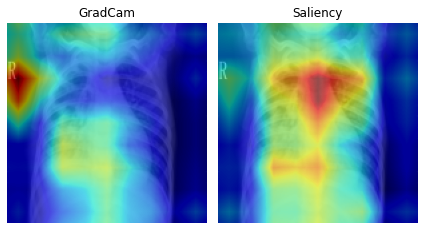

Figura person1950_bacteria_4881.jpeg


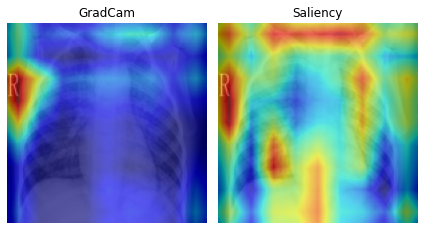

Figura person1946_bacteria_4875.jpeg


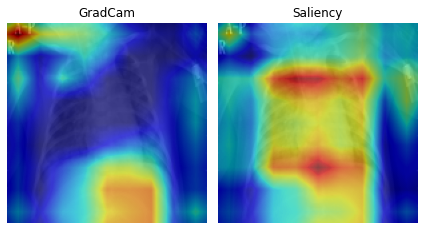

Figura person1951_bacteria_4882.jpeg


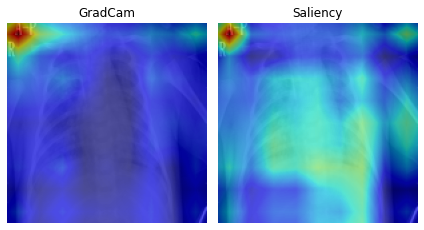

Figura person1949_bacteria_4880.jpeg


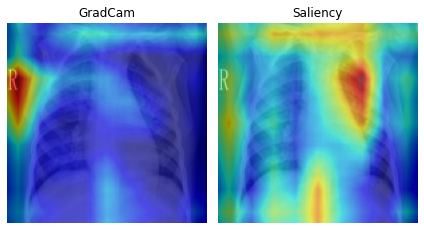

Figura person1952_bacteria_4883.jpeg


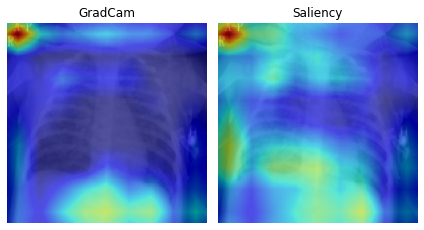

Figura person1947_bacteria_4876.jpeg


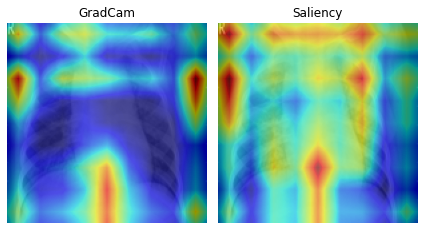

Figura person1946_bacteria_4874.jpeg


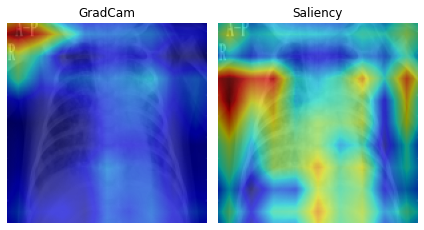

In [ ]:
path="/content/drive/MyDrive/Aprendizaje_maquina/Tareas/Tarea_02/data/val/PNEUMONIA/"
filenames=ls(path)
for i,filename in enumerate(filenames):
    print(f"Figura {filename}")
    file_full=join(path,filename)
    img,img_array = get_img_array(file_full,
                                  (150,150))
    heatmaps = make_gradcam_heatmap(img_array, 
                                    base_model, 
                                    last_conv_layer_name, 
                                    classifier_layer_names)
    show_hotmap_2(img,heatmaps)